In [1]:
import math
import numpy  as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from dataclasses import dataclass
from pathlib import Path
from tqdm    import tqdm
from typing  import Iterable
import random

import yaml

In [2]:
ANALOGOUS = np.array([['#0CE879', '#0CF23E', '#12DB00', '#70F20C', '#B8E80C'],
                      ['#E8A40C', '#F2940C', '#DB6300', '#F2520C', '#E82F0C'],
                      ['#3769FA', '#318BDE', '#42CEF5', '#31DED5', '#37FAB9'],
                      ['#DFFA17', '#DED114', '#F4D221', '#DEA814', '#FAA717'],
                      ['#FA4612', '#DE2010', '#F51D4F', '#DE10A7', '#DD12FA'],
                      ['#FA0AF5', '#A609DE', '#7C15F5', '#3209DE', '#0A1CFA'],
                      ['#670FFA', '#220DDE', '#1B3EF5', '#0D67DE', '#0FB2FA']])

DISTINCT = np.hstack([ANALOGOUS.T[2], ANALOGOUS.T[4], ANALOGOUS.T[0], ANALOGOUS.T[3], ANALOGOUS.T[1]]).flatten()


In [3]:
def draw_var_plot(ax, x, y, var, color, label):
    ax.plot(x, y, label=label, c=color, linewidth=3)
    if var is not None:
        ax.fill_between(x, y-var, y+var, alpha=0.3, facecolor=color)

In [4]:
plots = [{'title': 'Door - Performance Improvement',
          'data': [
                  #  {'file': 'data/bopt_is_door_p3_n00_hpo_we_sR_f16e0b.csv',
                  #   'label': 'BOpt: $k = 3, \omega = 0.2, \mu = 0.0, \Sigma = 0.4, eig$'},
                  #  {'file': 'data/bopt_is_door_p5_n00_hpo_we_sR_0603e5.csv',
                  #   'label': 'BOpt: $k = 5, \omega = 0.2, \mu = 0.0, \Sigma = 0.4, eig$'},
                   {'file': 'data/bopt_is_door_p7_n00_hpo_we_sR_277fe0.csv',
                    'label': 'BOpt-GMM'}, # : $k = 7, \omega = 0.2, \mu = 0.0, \Sigma = 0.4, eig$
                #    {'file': 'data/sacgmm_is_door_p3_n00_10_05_00_wp_sR_1f14c9.csv',
                #     'label': 'SG: $k = 3, \omega = 0.1, \mu = 0.05, \Sigma = 0.0$'},
                #    {'file': 'data/sacgmm_is_door_p5_n00_10_05_00_wp_sR_9359ce.csv',
                #     'label': 'SG: $k = 5, \omega = 0.1, \mu = 0.05, \Sigma = 0.0$'},
                   {'file': 'data/sacgmm_is_door_p7_n00_10_05_00_wp_sR_c7107f.csv',
                    'label': 'SAC-GMM'}, # : $k = 7, \omega = 0.1, \mu = 0.05, \Sigma = 0.0$
                  #  {'file': 'data/online_og_door_p3_n00_hpo_wp_sR_2c375a.csv',
                  #   'label': 'OG: $k = 3$'},
                  #  {'file': 'data/online_og_door_p5_n00_hpo_wp_sR_e0d0a9.csv',
                  #   'label': 'OG: $k = 5$'},
                   {'file': 'data/online_og_door_p7_n00_hpo_wp_sR_4b14c3.csv',
                    'label': 'Online-GMM'}, # : $k = 7$
                  ]},
         {'title': 'Hatch - Performance Improvement',
          'data': [
                  #  {'file': 'data/bopt_is_sd_p3_n00_hpo_we_sR_8ca28c.csv',
                  #   'label': 'BOpt: $k = 3, \omega = 0.2, \mu = 0.0, \Sigma = 0.4, rot$'},
                  #  {'file': 'data/bopt_is_sd_p5_n00_hpo_we_sR_72029f.csv',
                  #   'label': 'BOpt: $k = 5, \omega = 0.2, \mu = 0.3, \Sigma = 0.0$'},
                   {'file': 'data/bopt_is_sd_p7_n00_hpo_we_sR_48c5a6.csv',
                    'label': 'BOpt-GMM'}, # : $k = 7, \omega = 0.2, \mu = 0.0, \Sigma = 0.4, eig$
                #    {'file': 'data/sacgmm_is_sd_p3_n00_10_05_00_wp_sR_50d215.csv',
                #     'label': 'SG: $k = 3, \omega = 0.1, \mu = 0.05, \Sigma = 0.0$'},
                #    {'file': 'data/sacgmm_is_sd_p5_n00_10_05_00_wp_sR_92eda0.csv',
                #     'label': 'SG: $k = 5, \omega = 0.1, \mu = 0.05, \Sigma = 0.0$'},
                   {'file': 'data/sacgmm_is_sd_p7_n00_10_05_00_wp_sR_cf3264.csv',
                    'label': 'SAC-GMM'}, # : $k = 7, \omega = 0.1, \mu = 0.05, \Sigma = 0.0$
                  #  {'file': 'data/online_og_sd_p3_n00_hpo_wp_sR_13380c.csv',
                  #   'label': 'OG: $k = 3$'},
                  #  {'file': 'data/online_og_sd_p5_n00_hpo_wp_sR_1fbed9.csv',
                  #   'label': 'OG: $k = 5$'},
                   {'file': 'data/online_og_sd_p7_n00_hpo_wp_sR_11a24b.csv',
                    'label': 'Online-GMM'}, # : $k = 7$
                    ]
          }]

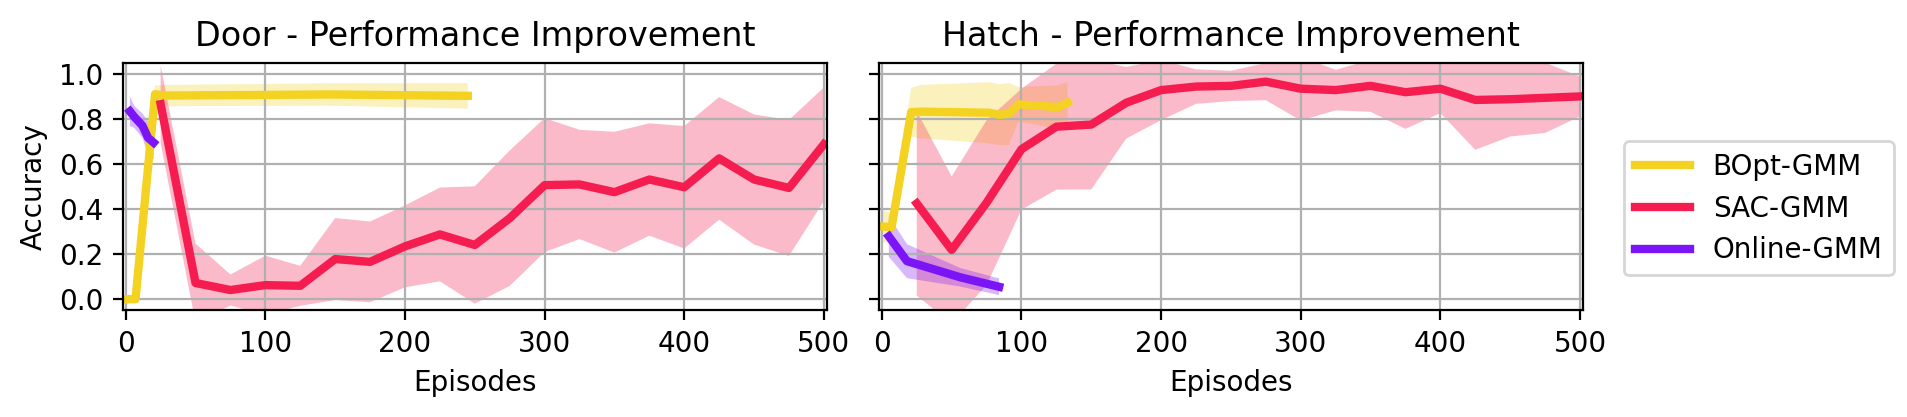

In [5]:
n_cols = 2
n_rows = int(math.ceil(len(plots) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=((12 * n_cols) / 2.54, (5 * n_rows) / 2.54), layout='constrained', dpi=200)

legend = {}
colors = {}

for x, (plot, ax) in enumerate(zip(plots, axes.flatten())):  # type data: AccuracyStat
    if x % n_cols == 0:
        ax.set_yticks(np.linspace(0.0, 1.0, 6))
        ax.set_ylabel('Accuracy')
    else:
        ax.set_yticks(np.linspace(0.0, 1.0, 6), [])

    ax.set_xlabel('Episodes')
    ax.set_xticks(np.linspace(0, 500, 6))
    # if x == 1 or x == len(data) - 1:
    ax.set_title(plot['title'])
    ax.grid(True)
    ax.set_ylim((0 - 0.05, 1.0 + 0.05))
    ax.set_xlim((0 - 2, 500 + 2))
    # ax.hlines(ac_stat.baseline, *ax.get_xlim(), color='#ee3322', linestyle='dotted')

    for data in plot['data']:
        label = data['label']

        if label not in colors:
            colors[label] = ANALOGOUS.T[2][3:][len(colors)]

        df = pd.read_csv(data['file'])
        df_data = df.to_numpy()

        draw_var_plot(ax, df_data.T[0], df_data.T[1], df_data.T[2], colors[label], label)

        handles, labels = ax.get_legend_handles_labels()
        legend.update(dict(zip(labels, handles)))

    # if x == n_cols - 1:
    #     ax.legend()

fig.legend(legend.values(), legend.keys(), loc='outside right center', ncols=1)
fig.savefig(f'plots/summary.png')